<a href="https://colab.research.google.com/github/talhaanwarch/skin_lesion_diagnosis_app/blob/master/skin-tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
#file reading packages
#pytorch stuff
!pip install pytorch-lightning
!pip install torchmetrics
!pip install efficientnet_pytorch

In [3]:
import os
if (os.path.isfile('data.zip')) or (os.path.isdir('data')) is False:
  !wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip -O data.zip


--2021-06-17 21:32:55--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.101.32
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.101.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3593344681 (3.3G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.35G  23.0MB/s    in 2m 10s  

2021-06-17 21:35:05 (26.4 MB/s) - ‘data.zip’ saved [3593344681/3593344681]



In [4]:
%%capture
if os.path.isdir('data') is False:
  !mkdir data
  !unzip /content/data.zip -d data
  !unzip /content/data/images/imgs_part_1.zip -d data
  !unzip /content/data/images/imgs_part_2.zip -d data
  !unzip /content/data/images/imgs_part_3.zip -d data

  !mv  /content/data/imgs_part_1/* /content/data
  !mv  /content/data/imgs_part_2/* /content/data
  !mv  /content/data/imgs_part_3/* /content/data

  !rm -r /content/data/imgs_part_1
  !rm -r /content/data/imgs_part_2
  !rm -r /content/data/imgs_part_3
  !rm -r /content/data/images
  !rm -rf /content/data/__MACOSX

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv('/content/data/metadata.csv')
data.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,has_sewage_system,fitspatrick,region,diameter_1,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM,NaN,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,True,3.0,NECK,6.0,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACE,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HAND,NaN,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,False,1.0,FOREARM,5.0,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [7]:
df=data[['img_id','diagnostic']].copy()
df.img_id='data/'+df.img_id.astype(str)
df.columns=['image','label']
df.head()

,image,label
0,data/PAT_1516_1765_530.png,NEV
1,data/PAT_46_881_939.png,BCC
2,data/PAT_1545_1867_547.png,ACK
3,data/PAT_1989_4061_934.png,ACK
4,data/PAT_684_1302_588.png,BCC


In [8]:
train_df,val_df=train_test_split(df,test_size=0.1,random_state=42)
train_df,test_df=train_test_split(df,test_size=0.15,random_state=42)

In [9]:
encode={k:v for v,k in enumerate(train_df.label.unique())}
decode={v:k for v,k in enumerate(train_df.label.unique())}

In [10]:
train_df['label']=train_df['label'].map(encode)
train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image,label
1078,data/PAT_658_1266_149.png,0
203,data/PAT_997_14_40.png,1
174,data/PAT_162_252_773.png,0
1877,data/PAT_756_1496_599.png,2
120,data/PAT_426_842_458.png,0


In [11]:
val_df.loc[:,'label']=val_df.loc[:,'label'].map(encode)
val_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,image,label
1085,data/PAT_1186_680_578.png,2
2296,data/PAT_326_690_823.png,0
208,data/PAT_547_1033_911.png,0
1178,data/PAT_931_1762_69.png,1
282,data/PAT_1981_4023_673.png,1


In [12]:
test_df['label']=test_df['label'].map(encode)
test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image,label
1085,data/PAT_1186_680_578.png,2
2296,data/PAT_326_690_823.png,0
208,data/PAT_547_1033_911.png,0
1178,data/PAT_931_1762_69.png,1
282,data/PAT_1981_4023_673.png,1


In [13]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight


In [15]:
aug=transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=30),
                        transforms.RandomPerspective(0.05,0.2),
                    
                        transforms.ToTensor(),
                        transforms.Normalize([0.5820, 0.4512, 0.4023], [0.2217, 0.1858, 0.1705])

                        ])

In [16]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
class DataReader(torch.utils.data.Dataset):
    
    def __init__(self,df,transform=None):
        self.df = df    
        self.transform=transform
        
    def __getitem__(self,index):
     
        img_ind=self.df.image.values[index]
        label_ind=self.df.label.values[index]

        img = Image.open(img_ind).convert('RGB')
      
        if self.transform:
           img=self.transform(img) 
  
        return img ,label_ind
    
    def __len__(self):
        return len(self.df)

torch.Size([3, 224, 224])


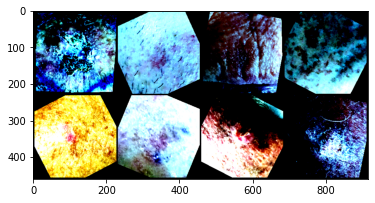

In [17]:
#testing above code
batch=next(iter(DataLoader(DataReader(train_df,aug), batch_size = 8, num_workers=1,shuffle=True)))
print(batch[0][0].shape)

from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
grid_img=torchvision.utils.make_grid(batch[0],4,4)
plt.imshow(grid_img.permute(1, 2, 0))

In [20]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.network=models.densenet121(pretrained=True)
    num_ftrs = self.network.classifier.in_features
    self.network.classifier = torch.nn.Sequential(
                          torch.nn.Linear(num_ftrs, 256), 
                          torch.nn.ReLU(), 

                          torch.nn.Linear(256, len(encode)))                   
  
  #parameters
    self.lr=0.001
    self.batch_size=32
    self.numworker=2
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.class_weights =torch.tensor(class_weight.compute_class_weight('balanced',\
                  np.unique(train_df.label),train_df.label),dtype=torch.float32)
    
  def forward(self,x):
    return self.network(x)

 

  def configure_optimizers(self):
    optimizer=torch.optim.Adam(params=self.parameters() )
    lr_schedulers ={'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor =0.5,patience =2),
                    'monitor': 'val/loss'}
    return [optimizer], [lr_schedulers]

  def train_dataloader(self):
    return DataLoader(DataReader(train_df,aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    train_acc=self.train_acc(pred,label)
    self.log('train/acc', train_acc, on_epoch=True,prog_bar=True)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(val_df,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    valid_acc=self.val_acc(pred,label)
    self.log('val/acc', valid_acc, on_epoch=True,prog_bar=True)
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    return loss


In [ ]:
early_stop_callback = EarlyStopping(monitor='vall/loss', min_delta=0.00, patience=3, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='/content/',
                                      filename='skin-{epoch:02d}-{val_loss:.2f}' )
model = OurModel()
trainer = Trainer(max_epochs=25, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback,checkpoint_callback]
                  )
trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type     | Params
---------------------------------------
0 | network   | DenseNet | 7.2 M 
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
---------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
14.436    Total estimated model params size (MB)


In [ ]:
#torch.save(model, '/content/drive/MyDrive/skin_full.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/skin_state.pt')


In [ ]:
test_loader=DataLoader(DataReader(test_df,aug), batch_size = 20, num_workers=model.numworker,shuffle=False)

In [ ]:
model.eval()
preds,labels=[],[]
for img, lab in test_loader:
  pred=model(img)
  preds.append(pred)
  labels.append(lab)


In [1]:
!rm -rf /content/lightning_logs